### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-01 22:44:20,920	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 12 (seed=2554956635, Wed Feb  1 22:44:22 2023)


In [3]:
trainer.train(1000, 'centered2')

         iter : 1
pop_best_eval : 3.224492073059082
  median_eval : -290.8539123535156
    mean_eval : -419.91448974609375
    best_eval : 3.224492073059082
   worst_eval : -1313.2193603515625

         iter : 2
pop_best_eval : 1.7665820121765137
  median_eval : -387.0982666015625
    mean_eval : -456.3296813964844
    best_eval : 3.224492073059082
   worst_eval : -1314.0390625

         iter : 3
pop_best_eval : -51.69647216796875
  median_eval : -642.2658081054688
    mean_eval : -521.9661865234375
    best_eval : 3.224492073059082
   worst_eval : -1314.0390625

         iter : 4
pop_best_eval : 1.4788541793823242
  median_eval : -381.8934631347656
    mean_eval : -447.44696044921875
    best_eval : 3.224492073059082
   worst_eval : -1673.4879150390625

         iter : 5
pop_best_eval : 2.390134334564209
  median_eval : -295.0254821777344
    mean_eval : -490.0111389160156
    best_eval : 3.224492073059082
   worst_eval : -1673.4879150390625

         iter : 6
pop_best_eval : -9.99054

In [4]:
network = trainer.problem.parameterize_net(trainer.searcher.status['center'])

In [5]:
network = trainer.get_trained_network()

#### Visualize trained network

In [6]:
organism = generate_organism(50, device)
graph = organism.toGraph()
visualizer = Visualizer()

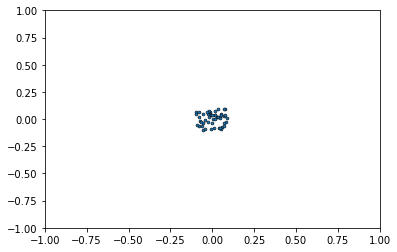

In [7]:
anim = visualizer.animate_organism(graph, network, frames=200)
IPython.display.HTML(anim)